In [29]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split

In [12]:
local_path='../data/'

In [14]:
data=[]
for images in os.listdir(local_path):
    if (images.endswith(".tif")):
        I = plt.imread(str(local_path+images))
        imarray = np.array(I)
        data.append(imarray)

In [15]:
# ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness

In [16]:
train_path = os.path.join(local_path,'train')
os.mkdir(train_path)

In [18]:
image_size = 224
train_generator = datagen.flow_from_directory(
        local_path,
        target_size=(image_size, image_size),
        batch_size=24,
        class_mode='categorical')

Found 44 images belonging to 1 classes.


In [20]:
from torchvision.transforms import ToTensor
import rasterio
from rasterio.plot import show
import numpy as np

path = "../data/train/Image0.tif"

with rasterio.open(path) as image:
    image_array = image.read()
torch_image = ToTensor()(image_array)
print(torch_image.shape)

/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([2560, 3, 1920])


/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/rasterio/__init__.py:277: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


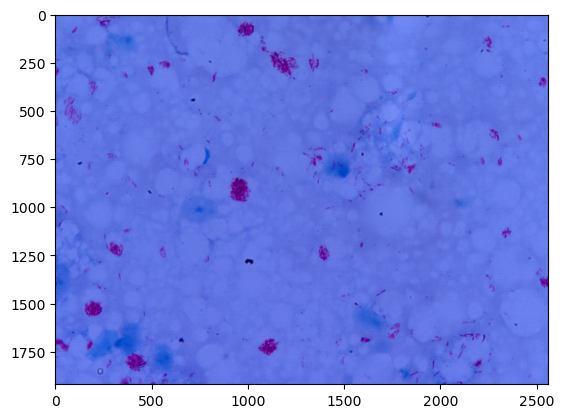

<AxesSubplot: >

In [21]:
show(image_array)

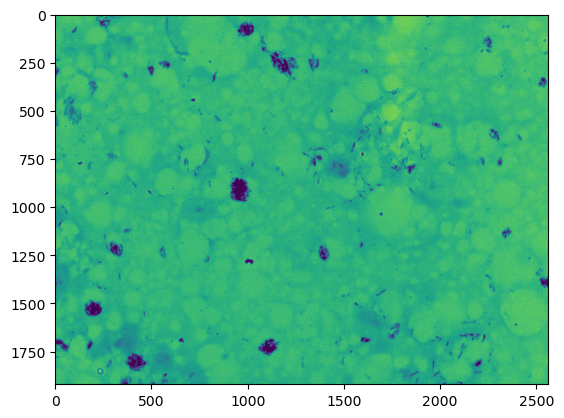

<AxesSubplot: >

In [27]:
ds = rasterio.open(path)
show((ds, 2), cmap='viridis')

## Canny edge detection

In [28]:

def Canny_detector(img, weak_th = None, strong_th = None):
      
    # conversion of image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       
    # Noise reduction step
    img = cv2.GaussianBlur(img, (5, 5), 1.4)
       
    # Calculating the gradients
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)
      
    # Conversion of Cartesian coordinates to polar 
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)
       
    # setting the minimum and maximum thresholds 
    # for double thresholding
    mag_max = np.max(mag)
    if not weak_th:weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5
      
    # getting the dimensions of the input image  
    height, width = img.shape
       
    # Looping through every pixel of the grayscale 
    # image
    for i_x in range(width):
        for i_y in range(height):
               
            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
               
            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
              
            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
              
            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
              
            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1
              
            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
               
            # Non-maximum suppression step
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x]= 0
                    continue
   
            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x]= 0
   
    weak_ids = np.zeros_like(img)
    strong_ids = np.zeros_like(img)              
    ids = np.zeros_like(img)
       
    # double thresholding step
    for i_x in range(width):
        for i_y in range(height):
              
            grad_mag = mag[i_y, i_x]
              
            if grad_mag<weak_th:
                mag[i_y, i_x]= 0
            elif strong_th>grad_mag>= weak_th:
                ids[i_y, i_x]= 1
            else:
                ids[i_y, i_x]= 2
       
       
    # finally returning the magnitude of
    # gradients

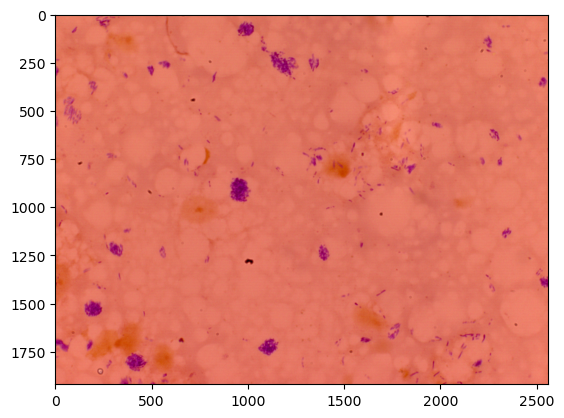

In [32]:
import cv2
frame = cv2.imread(path)
plt.imshow(frame)

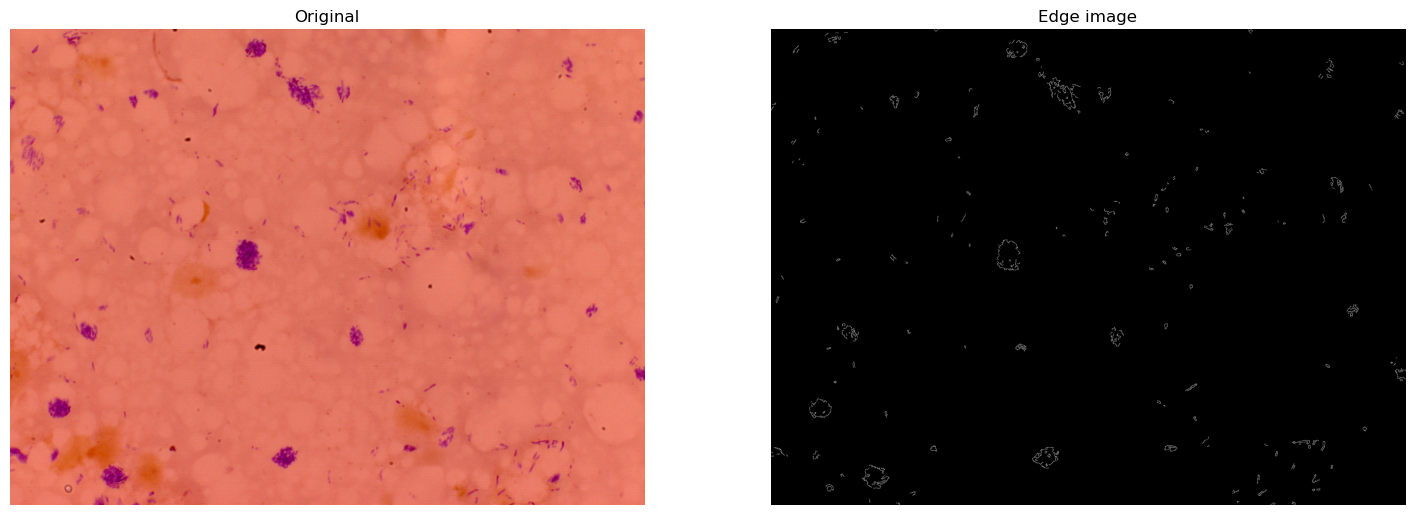

In [35]:
edges = cv2.Canny(image=frame, threshold1=100, threshold2=200)
 
plt.figure(figsize=(18,19))
plt.subplot(121)
plt.imshow(frame, cmap='gray')
plt.title('Original') 
plt.axis("off")
 
plt.subplot(122)
plt.imshow(edges, cmap='gray')
plt.title('Edge image')
plt.axis("off")
plt.show()

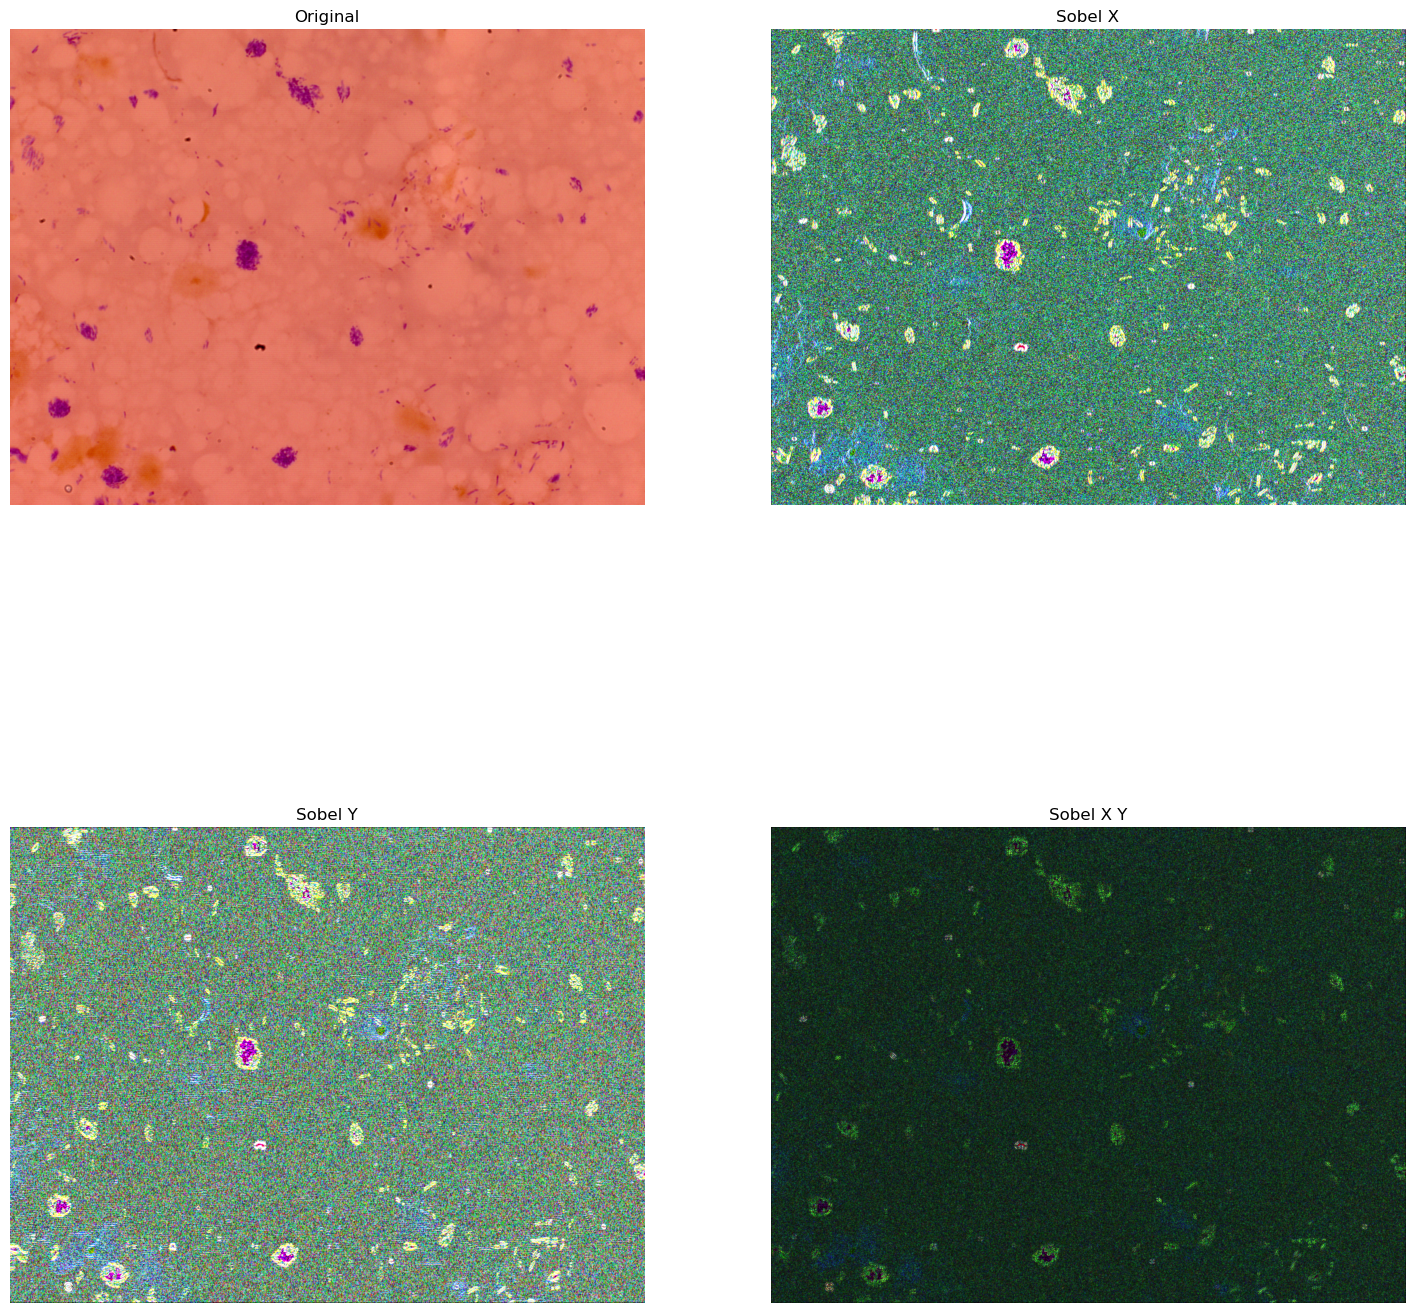

In [37]:
sobelx = cv2.Sobel(src=frame, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) 
filtered_image_x = cv2.convertScaleAbs(sobelx)
 
sobely = cv2.Sobel(src=frame, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5)
filtered_image_y = cv2.convertScaleAbs(sobely)
 
sobelxy = cv2.Sobel(src=frame, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
filtered_image_xy = cv2.convertScaleAbs(sobelxy)
 
plt.figure(figsize=(18,19))
plt.subplot(221)
plt.imshow(frame, cmap='gray')
plt.title('Original') 
plt.axis("off")
 
plt.subplot(222)
plt.imshow(filtered_image_x, cmap='gray')
plt.title('Sobel X') 
plt.axis("off")
 
plt.subplot(223)
plt.imshow(filtered_image_y, cmap='gray')
plt.title('Sobel Y') 
plt.axis("off")
 
plt.subplot(224)
plt.imshow(filtered_image_xy, cmap='gray')
plt.title('Sobel X Y')
plt.axis("off")
plt.show()